## Train the Ensemble

In [1]:
from src.models.transfer_nlp_utils import EnsembleTrainer
params = {
    'num_epochs': 10,
    'weight_decay': 0.1,
    'adam_epsilon': 1e-6,
    'model_name': 'roberta-base',
    'max_grad_norm': 1.0,
    'lr': 1e-5,
    'bs': 64,
    'device': 'cuda',
    'task': 'cola',
    'data_dir': '../data/external/CoLA',
    'max_seq_length': 50,          
    'metric_name': 'mcc',
    'patience': 3,
    'seed': random.randint(1, 1000),
    'n': -1,
    'total_steps': 5336, 
    'warmup_steps': 320
}

trainer = EnsembleTrainer(n_models=5)
trainer.run(params)

Training roberta-base with lr = 1e-05,bs = 64, n = -1
------------------------------------------------------------------------------------------------------


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch   1/10 | Loss:  0.66 (T)  0.60 (V) | MCC: 0.002 (T) 0.000 (V) | LR: 4.2e-06 | Time: 32.50s 
------------------------------------------------------------------------------------------------------
Epoch   2/10 | Loss:  0.27 (T)  0.25 (V) | MCC: 0.182 (T) 0.450 (V) | LR: 8.4e-06 | Time: 32.08s 
------------------------------------------------------------------------------------------------------
Epoch   3/10 | Loss:  0.14 (T)  0.18 (V) | MCC: 0.533 (T) 0.459 (V) | LR: 9.8e-06 | Time: 32.08s 
------------------------------------------------------------------------------------------------------
Epoch   4/10 | Loss:  0.08 (T)  0.12 (V) | MCC: 0.657 (T) 0.532 (V) | LR: 9.6e-06 | Time: 32.05s 
------------------------------------------------------------------------------------------------------
Epoch   5/10 | Loss:  0.05 (T)  0.10 (V) | MCC: 0.745 (T) 0.575 (V) | LR: 9.3e-06 | Time: 32.07s 
--------------------------------------------------------------------------------------------------

Epoch   9/10 | Loss:  0.01 (T)  0.07 (V) | MCC: 0.891 (T) 0.581 (V) | LR: 8.2e-06 | Time: 32.05s 
------------------------------------------------------------------------------------------------------
Epoch  10/10 | Loss:  0.01 (T)  0.06 (V) | MCC: 0.909 (T) 0.568 (V) | LR: 8e-06 | Time: 30.28s 
------------------------------------------------------------------------------------------------------
Training complete 5.32m
4/5 models (seed=756)
Training roberta-base with lr = 1e-05,bs = 64, n = -1
------------------------------------------------------------------------------------------------------
Epoch   1/10 | Loss:  0.67 (T)  0.60 (V) | MCC: -0.011 (T) 0.000 (V) | LR: 4.2e-06 | Time: 32.08s 
------------------------------------------------------------------------------------------------------
Epoch   2/10 | Loss:  0.27 (T)  0.25 (V) | MCC: 0.196 (T) 0.409 (V) | LR: 8.4e-06 | Time: 31.67s 
-------------------------------------------------------------------------------------------------

In [37]:
len(trainer.models)

5

## Run Inference Using all the Models

In [34]:
from src.models.transfer_nlp_utils import DataProcessor, set_seed

In [23]:
import random
params['seed'] = random.randint(1, 1000)
set_seed(params['seed'])
dp = DataProcessor(params)
dp.create_loaders()

In [51]:
import torch
import numpy as np
import pandas as pd

class EnsembleInference:

    def __init__(self, params, dataloader):
        self.dataloader = dataloader
        self.params = params
        self.nv_conf = []
        self.nv_pred = []
        self.ens_pred = []
        self.ens_conf = []
        self.obs = []

    def run_inference(self, models):
        for batch in self.dataloader:
            self._infer_one_batch(batch, models)
        self._aggregate_results()

    def _infer_one_batch(self, batch, models):
        probas = []
        with torch.no_grad():
            xb, mb, _, yb = tuple(t.to(self.params["device"]) for t in batch)
            for i, model in enumerate(models):
                model['model'].eval()
                outputs = model['model'](input_ids=xb, attention_mask=mb, labels=yb)
                proba = torch.nn.functional.softmax(outputs[1], dim=1)
                if i == 0:
                    self.nv_conf.append(torch.max(proba, dim=1)[0].cpu().numpy())
                    self.nv_pred.append(proba[:,-1].cpu().numpy())
                probas.append(proba[:,-1].unsqueeze(-1))
            probas = torch.cat(probas, dim=1)
            assert probas[0,0] != probas[0,1], "Make sure models were trained with different seeds"
            self.ens_pred.append(probas.mean(dim=1).cpu().numpy())
            self.ens_conf.append(probas.std(dim=1).cpu().numpy())
            self.obs.append(yb.cpu().numpy())

    def _aggregate_results(self, pred_cutoff=0.5):
        df = pd.DataFrame({
            'nv_conf': np.concatenate(self.nv_conf), 
            'nv_pred': np.concatenate(self.nv_pred),
            'ens_pred': np.concatenate(self.ens_pred), 
            'ens_conf': np.concatenate(self.ens_conf),
            'obs': np.concatenate(self.obs)
        })
        df['nv_pred_cls'] = (df['nv_pred'] > pred_cutoff).astype(int)
        df['ens_pred_cls'] = (df['ens_pred'] > pred_cutoff).astype(int)
        self.results = df

In [52]:
ens = EnsembleInference(params, dp.valid_dataloader)
ens.run_inference(trainer.models)
ens.results.head()

## Calculate Coverage vs. Accuracy

In [59]:
from matplotlib import pyplot as plt

def sort_filter(df, pct, sort_key, ascending):
    n_obs = int(pct * df.shape[0])
    return df.sort_values(sort_key, ascending=ascending).head(n_obs)

def accuracy(y_pred, y_obs):
    return (y_pred==y_obs).mean()

def calc_accuracies(coverages, df, sort_key, ascending):
    accuracies = []
    for coverage in coverages:
        df_high_conf = sort_filter(df, coverage, sort_key+'_conf', ascending)
        accuracies.append(accuracy(df_high_conf[sort_key+'_pred_cls'], df_high_conf.obs))
    return accuracies

In [60]:
coverages = [1, 0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.3, 0.2, 0.1]
accuracies_ens = calc_accuracies(coverages, ens.results, 'ens', True)
accuracies_nv = calc_accuracies(coverages, ens.results, 'nv', False)

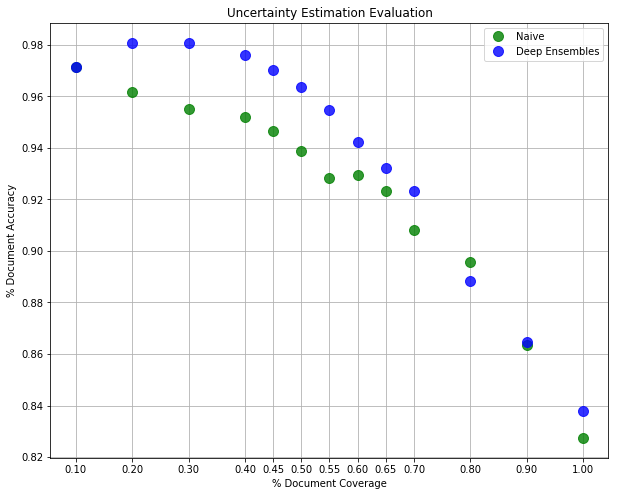

In [212]:
from src.visualization import scatter_plot

scatter_plot(
    coverages, 
    [accuracies_nv, accuracies_ens], 
    ['Naive', 'Deep Ensembles'], 
    '% Document Coverage',
    '% Document Accuracy',
    title='Uncertainty Estimation Evaluation',
    grid=True
)

## Monte Carlo Dropout

In [62]:
class MonteCarloDropout:
    """Runs Monte Carlo dropout inference and stores results. 
    Also stores naive confidence scores associated with softmax output.
    
    TODO: Reduce duplicate code by inheriting from a Inheritance class.
    """
    
    def __init__(self, model, dataloader, n_iter, device):
        self.model = model
        self.dataloader = dataloader
        self.n_iter = n_iter
        self.device = device
        self.nv_conf = []
        self.nv_pred = []        
        self.mc_pred = []
        self.mc_conf = []
        self.obs = []
        self.results = []
                    
    def _infer_one_batch(self, batch):
        probas = []
        with torch.no_grad():
            xb, mb, _, yb = tuple(t.to(self.device) for t in batch)
            for i in range(self.n_iter):
                outputs = self.model(input_ids=xb, attention_mask=mb, labels=yb)
                proba = torch.nn.functional.softmax(outputs[1], dim=1)
                if i == 0:
                    self.nv_conf.append(torch.max(proba, dim=1)[0].cpu().numpy())
                    self.nv_pred.append(proba[:,-1].cpu().numpy())
                probas.append(proba[:,-1].unsqueeze(-1))
            probas = torch.cat(probas, dim=1)
            assert probas[0,0] != probas[0,1], 'Make sure dropout is turned on'
            self.mc_pred.append(probas.mean(dim=1).cpu().numpy())
            self.mc_conf.append(probas.std(dim=1).cpu().numpy())
            self.obs.append(yb.cpu().numpy())
            
    def _aggregate_results(self, pred_cutoff=0.5):
        df = pd.DataFrame({
            'nv_conf': np.concatenate(self.nv_conf), 
            'nv_pred': np.concatenate(self.nv_pred),
            'mc_pred': np.concatenate(self.mc_pred), 
            'mc_conf': np.concatenate(self.mc_conf),
            'obs': np.concatenate(self.obs)
        })
        df['nv_pred_cls'] = (df['nv_pred'] > pred_cutoff).astype(int)
        df['mc_pred_cls'] = (df['mc_pred'] > pred_cutoff).astype(int)
        self.results = df
        
    def run_inference(self):
        self.model.train()
        for batch in self.dataloader:
            self._infer_one_batch(batch)
        self._aggregate_results()

In [77]:
mcdo = MonteCarloDropout(trainer.models[0]['model'], dp.valid_dataloader, 25, 'cuda')
mcdo.run_inference()
mcdo.results.head()

,nv_conf,nv_pred,mc_pred,mc_conf,obs,nv_pred_cls,mc_pred_cls
0,0.996588,0.996588,0.992405,0.004571,1,1,1
1,0.994911,0.994911,0.995794,0.003059,1,1,1
2,0.725902,0.725902,0.747549,0.276612,1,1,1
3,0.996838,0.996838,0.995617,0.002905,1,1,1
4,0.953089,0.953089,0.855065,0.200805,0,1,1


In [78]:
accuracies_mc = calc_accuracies(coverages, mcdo.results, 'mc', True)

In [229]:
coverages.reverse()

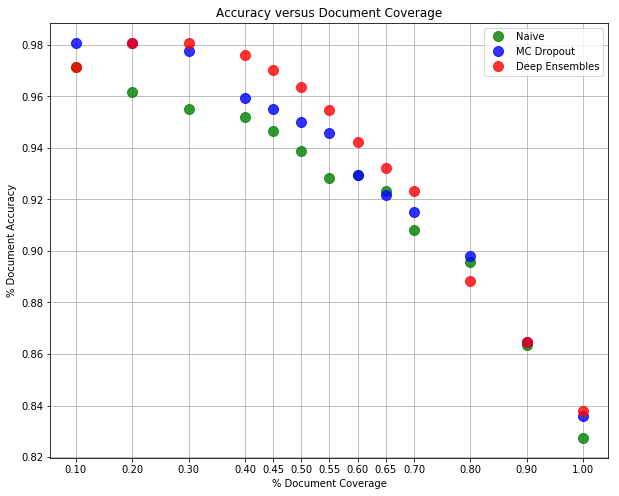

In [230]:
scatter_plot(
    coverages,
    [accuracies_nv, accuracies_mc, accuracies_ens], 
    ['Naive', 'MC Dropout', 'Deep Ensembles'], 
    '% Document Coverage',
    '% Document Accuracy',
    title='Accuracy versus Document Coverage',
    grid=True
)

In [225]:
pd.DataFrame({
    '% Coverage': 100*pd.Series(coverages).sort_values(ascending=False),
    'Naive': accuracies_nv, 
    'MC Dropout': accuracies_mc, 
    'Ensembles': accuracies_ens
})

,% Coverage,Naive,MC Dropout,Ensembles
12,100.0,0.827421,0.836050,0.837967
11,90.0,0.863539,0.864606,0.864606
10,80.0,0.895683,0.898082,0.888489
9,70.0,0.908219,0.915068,0.923288
8,65.0,0.923191,0.921713,0.932053
7,60.0,0.929600,0.929600,0.942400
6,55.0,0.928447,0.945899,0.954625
5,50.0,0.938580,0.950096,0.963532
4,45.0,0.946695,0.955224,0.970149
3,40.0,0.952038,0.959233,0.976019


## Accuracy vs. Confidence

In [144]:
def make_bin(df, x_lab):
    df[x_lab + '_bin'] = pd.qcut(df[x_lab], q = 10, labels = list(range(10)))
    return df

def make_bins(df):
    df = make_bin(df, 'nv_conf')
    df = make_bin(df, 'mc_conf')
    df = make_bin(df, 'ens_conf')
    return df

def calc_acc_bin(df, bin_conf, bin_cls, reverse=False):
    x = df.groupby(bin_conf).apply(lambda x: accuracy(x[bin_cls], x['obs']))
    x_li = x.values.tolist()
    if reverse: x_li.reverse()
    return x_li

In [145]:
df = make_bins(ens.results)
acc_nv = calc_acc_bin(df, 'nv_conf_bin', 'nv_pred_cls')
acc_mc = calc_acc_bin(df, 'mc_conf_bin', 'mc_pred_cls', True)
acc_ens = calc_acc_bin(df, 'ens_conf_bin', 'ens_pred_cls', True)

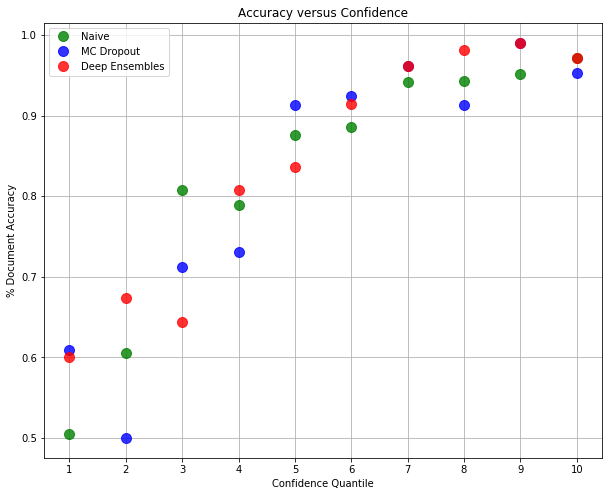

In [228]:
scatter_plot(
    list(range(1, 11)), 
    [acc_nv, acc_mc, acc_ens], 
    ['Naive', 'MC Dropout', 'Deep Ensembles'],
    'Confidence Quantile',
    '% Document Accuracy',
    title='Accuracy versus Confidence',
    grid=True
)

In [211]:
pd.DataFrame({
    'Confidence':list(range(1,11)),
    'Naive Softmax': acc_nv, 
    'MC Dropout': acc_mc, 
    'Ensembles': acc_ens
})

,Confidence,Naive Softmax,MC Dropout,Ensembles
0,1,0.504762,0.609524,0.600000
1,2,0.605769,0.500000,0.673077
2,3,0.807692,0.711538,0.644231
3,4,0.788462,0.730769,0.807692
4,5,0.876190,0.913462,0.836538
5,6,0.885714,0.923810,0.914286
6,7,0.941748,0.961538,0.961538
7,8,0.942308,0.913462,0.980769
8,9,0.951923,0.990385,0.990385
9,10,0.971429,0.952381,0.971429
